# An√°lise de Sentimento e Classifica√ß√£o de Temas

**Resumo dos passos**

- **Extra√ß√£o e Tratamentos de Texto**
    - Extra√ß√£o de 15 mil coment√°rios por empresa na Play Store
    - Fun√ß√£o de tratamento de texto: tradu√ß√£o de emojis, remo√ß√£o de stopwords, lemmentiza√ß√£o e etc
- **An√°lise de Sentimentos e Emo√ß√µes**
    - Verifiica√ß√£o do per√≠odo de coment√°rios para cada empresa
    - Aplica√ß√£o da fun√ß√£o com os modelos de sentimento e emo√ß√£o do Pysentimiento
    - An√°lise por agrupamento por notas (n√£o √© t√£o eficiente)
    - An√°lise por agrupamento por vers√£o (n√£o √© t√£o eficiente)
    - An√°lise por sentimento: vis√£o geral, reclassifica√ß√£o para sentimento menos ou mais forte e sentimentos neutros para positivos e negativos
    - An√°lise por emo√ß√£o: aplica√ß√£o da fun√ß√£o de emo√ß√µes em grandes sentimentos e vis√£o geral
- **Classifica√ß√£o de Temas**
    - Cria√ß√£o manual dos temas e aplica√ß√£o da fun√ß√£o de classifica√ß√£o de temas
    - Gera√ß√£o do sentimento m√©dio por tema e vis√£o em gr√°fico de dispers√£o
    - An√°lise em amostra de coment√°rios positivos e negativos
- **Passos Pensados, mas n√£o eficientes**
    - Tratamento de abrevia√ß√µes e g√≠rias seria algo muito complexo
    - Aplica√ß√£o da an√°lise de ironia, classificou quase todos coment√°rios como ironicos
    - A classifica√ß√£o de temas para sentimento n√£o fez tanto sentido por conta de estarmos usando o sentimento m√©dio por tema (neg, neu, pos)
    - Gr√°ficos de wordcloud n√£o foram eficiente para identificar os principais assuntos por temas
- **Etapas Futuras**
    - Reaplicar a an√°lise futuramente para entender a evolu√ß√£o dos sentimentos

In [1]:
#Para realizar paralelismo
import swifter

#Coletados Coment√°rios
from google_play_scraper import Sort, reviews

#Armazenamento em DF
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

#Transformar a coluna de vers√µes para fazer filtro melhores
from packaging.version import parse

#Tratamentos
import re
import emoji
import nltk
from nltk.corpus import stopwords
import stanza

#Sentimentos dos Coment√°rios
from pysentimiento import create_analyzer

#Gr√°ficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

c:\Users\Computador\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
#Download de pacotes
nltk.download("stopwords")
stanza.download('pt')

nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-10 16:24:06 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-10 16:24:06 INFO: Downloading default packages for language: pt (Portuguese) ...
2025-06-10 16:24:07 INFO: File exists: C:\Users\Computador\stanza_resources\pt\default.zip
2025-06-10 16:24:10 INFO: Finished downloading models and saved to C:\Users\Computador\stanza_resources
2025-06-10 16:24:10 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-06-10 16:24:10 INFO: Downloaded file to C:\Users\Computador\stanza_resources\resources.json
2025-06-10 16:24:11 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package         |
-------------------------------
|

## Fun√ß√µes 
**tratamento_de_texto**: Funciona para realizar limpezas com o nome da operados para o termo "operados", porque a Claro e a Vivo podem ter algum tipo de conota√ß√£o espec√≠fica se interpretadas pelo modelo sentimento, transforma√ß√£o dos emojis para formatos textuais e qualquer coisa relacionadas a poss√≠veis links nos comentar√°ios. Al√©m da lemmatiza√ß√£o dos coment√°rios para um formato mais geral das palavras. 

**classificar_tema**: Ap√≥s testar alguns modelos de classifica√ß√£o de t√≥picos, optei por fazer a classifica√ß√£o manual dos temas mais falados com uma lista de termos agrupados em grandes temas gerais que ocorrem com esse setor.

**analisar_sentimento_todos**: O Pysentimiento possui 4 fun√ß√µes de an√°lise de sentimento, optei de realizar a an√°lise sentimento e emo√ß√£o. Para as emo√ß√µes, que s√£o gerados diversas emo√ß√µes em ingl√™s, optei por agrupar em 8 grandes emo√ß√µes para melhorar a an√°lise.

In [18]:
stopwords_pt = set(stopwords.words("portuguese"))

In [19]:
def tratamento_de_texto(texto):
    texto = emoji.demojize(texto, language="pt")
    texto = texto.lower()
    texto = re.sub(r'\b(vivo|claro|tim)\b', 'operadora', texto)
    texto = re.sub(r'(:[^:\s]+:)', r' \1 ', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-z√°-√∫√†-√º√ß\s]", "", texto)
    texto = re.sub(r'\s+', ' ', texto).strip()

    doc = nlp(texto)
    
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words if word.lemma not in stopwords_pt and len(word.lemma) > 2]
    
    return " ".join(lemmas)

In [35]:
temas_manuais = {
    "Operadora": [r"operadora"],
    "App": [r"\bapp\b", r"\baplicativo\b"],
    "Login": [r"logar", r"\blogin\b", r"acessar", r"entrar", r"cadastrar", r"cadastro"],
    "Atendimento": [r"atendimento", r"chat", r"suporte", r"atendente", r"fale conosco", r"n√£o responde", r"reclame"],
    "Usabilidade": [r"interface", r"usabilidade", r"navega√ß√£o", r"bot√£o", r"menu", r"layout", r"tela", r"confuso", r"dif√≠cil"],
    "Conta": [r"fatura", r"boleto", r"cobran√ßa", r"pagamento", r"conta", r"valor indevido", r"pre√ßo errado"],
    "Plano": [r"servi√ßo", r"plano", r"contrato", r"assinatura", r"benef√≠cio", r"pacote", r"promo√ß√£o", r"desconto", r"benef√≠cio", r"cashback", r"oferta"],
    "Internet": [r"internet", r"sinal", r"conex√£o", r"velocidade", r"3g", r"4g", r"5g", r"wi[- ]?fi", r"queda", r"recarga", r"cr√©ditos", r"saldo"],
    "Desempenho": [r"bug", r"erro", r"trava", r"lento", r"crash", r"problema", r"instabilidade", r"atualiza√ß√£o", r"atualizei", r"vers√£o", r"nova vers√£o", r"√∫ltima atualiza√ß√£o"],
    "Notifica√ß√µes": [r"notifica√ß√£o", r"alerta", r"mensagem push", r"aviso", r"push", r"mensagem", r"sms"]
}

In [57]:
temas_manuais_abrevidado = {
    "Op.": [r"operadora"],
    "App": [r"\bapp\b", r"\baplicativo\b"],
    "Login": [r"logar", r"\blogin\b", r"acessar", r"entrar", r"cadastrar", r"cadastro"],
    "Atend.": [r"atendimento", r"chat", r"suporte", r"atendente", r"fale conosco", r"n√£o responde", r"reclame"],
    "Usab.": [r"interface", r"usabilidade", r"navega√ß√£o", r"bot√£o", r"menu", r"layout", r"tela", r"confuso", r"dif√≠cil"],
    "Conta": [r"fatura", r"boleto", r"cobran√ßa", r"pagamento", r"conta", r"valor indevido", r"pre√ßo errado"],
    "Plano": [r"servi√ßo", r"plano", r"contrato", r"assinatura", r"benef√≠cio", r"pacote", r"promo√ß√£o", r"desconto", r"benef√≠cio", r"cashback", r"oferta"],
    "Net": [r"internet", r"sinal", r"conex√£o", r"velocidade", r"3g", r"4g", r"5g", r"wi[- ]?fi", r"queda", r"recarga", r"cr√©ditos", r"saldo"],
    "Desemp.": [r"bug", r"erro", r"trava", r"lento", r"crash", r"problema", r"instabilidade", r"atualiza√ß√£o", r"atualizei", r"vers√£o", r"nova vers√£o", r"√∫ltima atualiza√ß√£o"],
    "Not.": [r"notifica√ß√£o", r"alerta", r"mensagem push", r"aviso", r"push", r"mensagem", r"sms"]
}

In [37]:
def classificar_tema(texto, temas_dict):
    texto = texto.lower()
    temas_encontrados = []
    for tema, padroes in temas_dict.items():
        for padrao in padroes:
            if re.search(padrao, texto):
                temas_encontrados.append(tema)
                break  # Evita m√∫ltiplas adi√ß√µes do mesmo tema
    return temas_encontrados  # Sem categoria 'Outro'

In [22]:
analyzers = {
    "sentiment": create_analyzer(task="sentiment", lang="pt"),
    "emotion": create_analyzer(task="emotion", lang="pt"),
}

# Grupos para emo√ß√µes resumidas
grupos_emocoes = {
    "alegria": ["admiration", "amusement", "approval", "excitement",
                "gratitude", "joy", "love", "optimism", "pride"],
    "tristeza": ["disappointment", "remorse", "sadness"],
    "raiva": ["anger", "annoyance", "disapproval", "disgust"],
    "medo": ["fear", "nervousness", "embarrassment"],
    "surpresa": ["surprise", "realization"],
    "confianca": ["curiosity", "desire", "caring"],
    "confusao": ["confusion"],
    "neutro": ["neutral", None]
}

def analisar_sentimento_todos(texto, analyzers=analyzers):
    if not isinstance(texto, str) or not texto.strip():
        return pd.Series()

    dados = {}

    for tipo, analyzer in analyzers.items():
        resultado = analyzer.predict(texto)

        # Ajuste seguro do output
        if isinstance(resultado.output, list):
            saida = resultado.output[0] if resultado.output else None
        else:
            saida = resultado.output

        # Para emo√ß√£o, substituir output pela categoria agregada
        if tipo == "emotion":
            # P√≥s-processamento: agregando emo√ß√µes
            grupo_probs = {}
            for grupo, emocoes in grupos_emocoes.items():
                soma = sum(resultado.probas.get(e, 0) for e in emocoes)
                dados[f"{tipo}_{grupo}"] = soma
                grupo_probs[grupo] = soma
            
            # Encontrar o grupo com maior probabilidade
            if grupo_probs:
                grupo_principal = max(grupo_probs, key=grupo_probs.get)
            else:
                grupo_principal = None

            dados[f"{tipo}_output"] = grupo_principal
        else:
            # Mant√©m output original
            dados[f"{tipo}_output"] = saida
            # Mant√©m probas originais
            for k, v in resultado.probas.items():
                dados[f"{tipo}_{k}"] = v

    return pd.Series(dados)


---
# Extra√ß√£o de Coment√°rios
Aproveitando um script feito em outro [notebook]('https://github.com/PedroReste/data_eng_insights/tree/main/web_scraping_comentarios_apps), ser√° coletado aproximadamente 15 mil coment√°rios de cada aplicativo na Play Store pela consist√™ncia dos dados em rela√ß√£o ao iOS. Al√©m do caso brasileiro de exister, de forma majorit√°ria, mais usu√°rios de Android do que iOS.

In [ ]:
qtd_comentarios = 15000

dados_android = []

apps = {
    "Claro": "com.nvt.cs",
    "TIM": "br.com.timbrasil.meutim",
    "Vivo": "br.com.vivo"
}

In [24]:
for app, app_id in apps.items():
    result, _ = reviews(
        app_id,
        lang='pt',
        country='br',
        sort=Sort.NEWEST,
        count=qtd_comentarios
    )
        
    for review in result:
        dados_android.append({
            "app": app,
            "score": review.get("score", None),
            "content": review.get("content", None),
            "app_version": review.get("appVersion", None),
            "date": review.get("at", None),
            "reply_content": review.get("replyContent", None),
            "reply_date": review.get("repliedAt", None)
        })

In [25]:
comentarios_android = pd.DataFrame(dados_android, columns=["date", "score", "app_version", "app",  "content"])
comentarios_android.to_csv("comentarios.csv", index=False)
comentarios_android.shape

(45000, 5)

---
# An√°lise de Sentimento
Nessa se√ß√£o ser√° aplicado os tratamentos necess√°rios aos coment√°rios extra√≠dos da Play Store, aplica√ß√£o dos modelos do Pysentimiento para entender os sentimentos e emo√ß√µes do coment√°rios e uma an√°lise encima das informa√ß√µes extraidas da store e da aplica√ß√£o dos modelos.

**Insights**
- O per√≠odo dos coment√°rios dos apps √© pr√≥ximo, estando entre 10/dez/2024 e 09/jun/2025, com 15 mil coment√°rios cada. Exceto a Vivo, que o per√≠do √© entre 13/abr/2025 e 09/jun/2025.

- Notas
    - Observando o geral das notas dos coment√°rios do per√≠odo, para todos os apps, se destaca a quantidade de avalia√ß√µes m√°ximas.
    - Exceto a TIM, que tamb√©m tem muitas avalia√ß√µes m√°ximas, as avalia√ß√µes de 1, s√£o maiores.
    - Observando as notas dos coment√°rios ao decorrer dos meses, o comportamento do geral se mant√©m para os meses tamb√©m.
    - N√£o fez tanto sentido tentar verificar a nota m√©dia por vers√£o do app que usu√°rios tinham quando comentaram.
- Sentimentos por Vers√£o
    - Os apps lan√ßam muitas vers√£o intermedi√°rias, que dificutam uma an√°lise mais aprofundada a partir dos coment√°rios. Nesse caso, n√£o foi t√£o relevante assim.
- Sentimentos 
    - Em um primeiro momento, encontrei diversos coment√°rios compostos de de frases curtas ou de uma ou duas palavras que foram classificados como neutros, mas poderiam ser possitivos ou negativos.
    - Estabelecendo um limite probabildiade, coment√°rios neutros acima 70% de serem neutros se matiam e abaixos, eram reclassificados como positivos ou negativos.
    - Com a reclassifica√ß√£o geral, houve um crescimento maior de sentimentos positivos para a Claro e a Vivo, enquanto cresceu mais os sentimento negativos para a TIM.
    - Detalhando os sentimentos negativos e positivos entre muito ou moderado, utilizando a mesma regra de 70% de probabilidade. A Vivo e Claro, possuem um comportamento muito semelhante.
    - No caso de TIM, se mantem distoante, com coment√°rios muito negativos na maioria.
    - Nas emo√ß√µes gerais, Vivo e Claro seguem um comportamento parecido, tendo como principal emo√ß√£o a **alegria**, em seguida da **neutralidade**. Enquanto as demais emo√ß√µes n√£o possuem expressividade.
    - A TIM distoa, tendo como principal emo√ß√£o a **netrualidade**, seguido de **alegria** e **raiva**, refletindo o sentimento geral dos coment√°rios.

### Informa√ß√µes Gerais

In [26]:
comentarios_android["content_proc"] = comentarios_android["content"].swifter.apply(tratamento_de_texto)

Pandas Apply: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 45000/45000 [1:12:54<00:00, 10.29it/s]


In [27]:
resultados = comentarios_android["content_proc"].swifter.apply(analisar_sentimento_todos)
df = pd.concat([comentarios_android, resultados], axis=1)

Pandas Apply: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 45000/45000 [51:36<00:00, 14.53it/s]  


In [102]:
print("Data m√≠nima da Claro: ", df[df['app']=='Claro']['date'].min())
print("Data m√≠nima da TIM: ", df[df['app']=='TIM']['date'].min())
print("Data m√≠nima da Vivo: ", df[df['app']=='Vivo']['date'].min())
print("Data m√°xima da Claro: ", df[df['app']=='Claro']['date'].max())
print("Data m√°xima da TIM: ", df[df['app']=='TIM']['date'].max())
print("Data m√°xima da Vivo: ", df[df['app']=='Vivo']['date'].max())

Data m√≠nima da Claro:  2024-12-11 11:32:18
Data m√≠nima da TIM:  2024-12-12 11:37:05
Data m√≠nima da Vivo:  2025-04-13 12:18:16
Data m√°xima da Claro:  2025-06-09 16:14:31
Data m√°xima da TIM:  2025-06-09 16:05:37
Data m√°xima da Vivo:  2025-06-09 16:22:06


In [ ]:
#Sentimento Geral do App
df_explodido = df.explode('app')

df_explodido['sentimento_continuo'] = (
    df_explodido['sentiment_POS'] * 1 +
    df_explodido['sentiment_NEU'] * 0 +
    df_explodido['sentiment_NEG'] * -1
)

df_tema = df_explodido.groupby('app').agg(
    volume=('app', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

df_tema

app  volume  sentimento_medio
0  Claro   15000          0.268696
1    TIM   15000         -0.223043
2   Vivo   15000          0.229890

### Notas
- Observando o geral das notas dos coment√°rios do per√≠odo, para todos os apps, se destaca a quantidade de avalia√ß√µes m√°ximas.
- Exceto a TIM, que tamb√©m tem muitas avalia√ß√µes m√°ximas, as avalia√ß√µes de 1, s√£o maiores.
- Observando as notas dos coment√°rios ao decorrer dos meses, o comportamento do geral se mant√©m para os meses tamb√©m.
- N√£o fez tanto sentido tentar verificar a nota m√©dia por vers√£o do app que usu√°rios tinham quando comentaram.

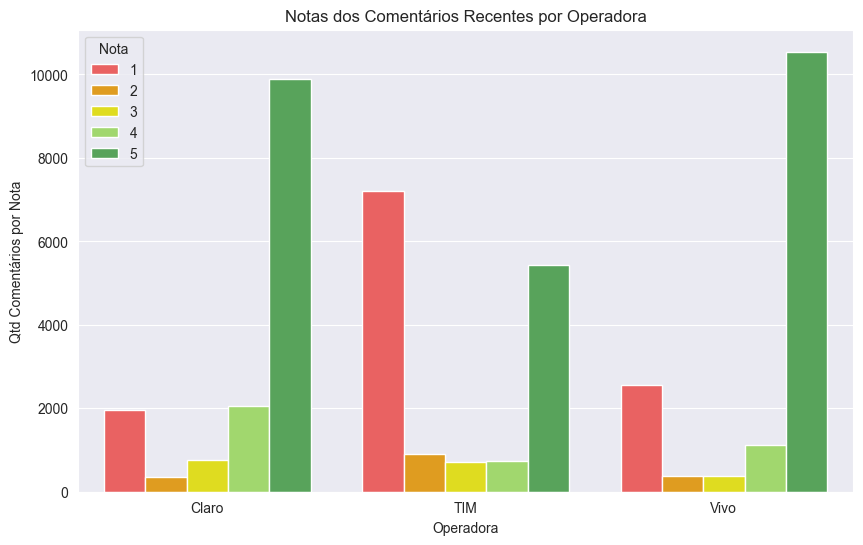

In [30]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plotar gr√°fico com hue simplificado
sns.countplot(
    data=df,
    x='app',
    hue='score',
    palette={1: '#FF4C4C', 2: '#FFA500', 3: "#FFFB00", 4: "#A0E95C", 5: '#4CAF50'},
    hue_order=[1, 2, 3, 4, 5]
)

plt.title("Notas dos Coment√°rios Recentes por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Qtd Coment√°rios por Nota")
plt.legend(title="Nota")

plt.show()

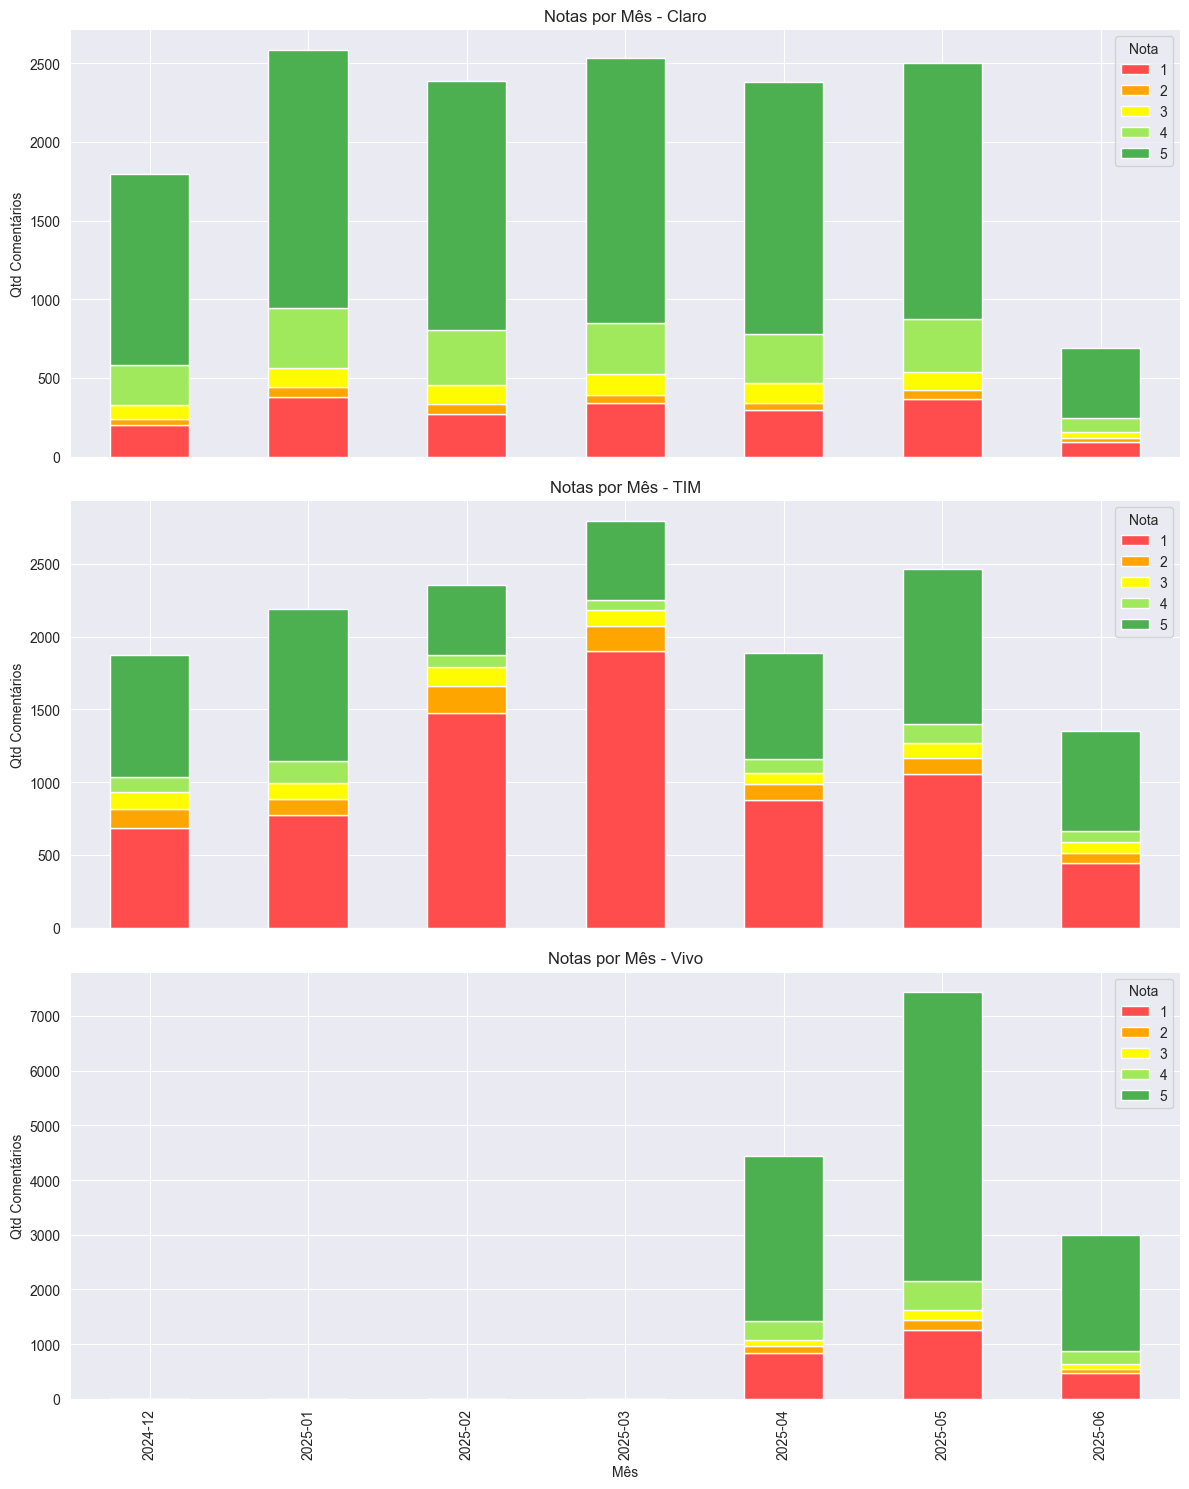

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['mes'] = df['date'].dt.to_period('M').astype(str)
todos_meses = sorted(df['mes'].unique())

cores = {1: '#FF4C4C', 2: '#FFA500', 3: "#FFFB00", 4: "#A0E95C", 5: '#4CAF50'}
apps = df['app'].unique()
n_apps = len(apps)

fig, axes = plt.subplots(n_apps, 1, figsize=(12, 5 * n_apps), sharex=True)

for i, app in enumerate(apps):
    df_app = df[df['app'] == app]

    dados = df_app.groupby(['mes', 'score']).size().unstack(fill_value=0)
    dados = dados.reindex(todos_meses, fill_value=0)
    
    for score in [1, 2, 3, 4, 5]:
        if score not in dados.columns:
            dados[score] = 0
    
    dados = dados[[1, 2, 3, 4, 5]]

    ax = axes[i] if n_apps > 1 else axes
    dados.plot(
        kind='bar',
        stacked=True,
        color=[cores[n] for n in dados.columns],
        ax=ax,
        title=f"Notas por M√™s - {app}"
    )
    ax.set_ylabel("Qtd Coment√°rios")
    ax.legend(title="Nota", loc='upper right')

plt.xlabel("M√™s")
plt.tight_layout()
plt.show()


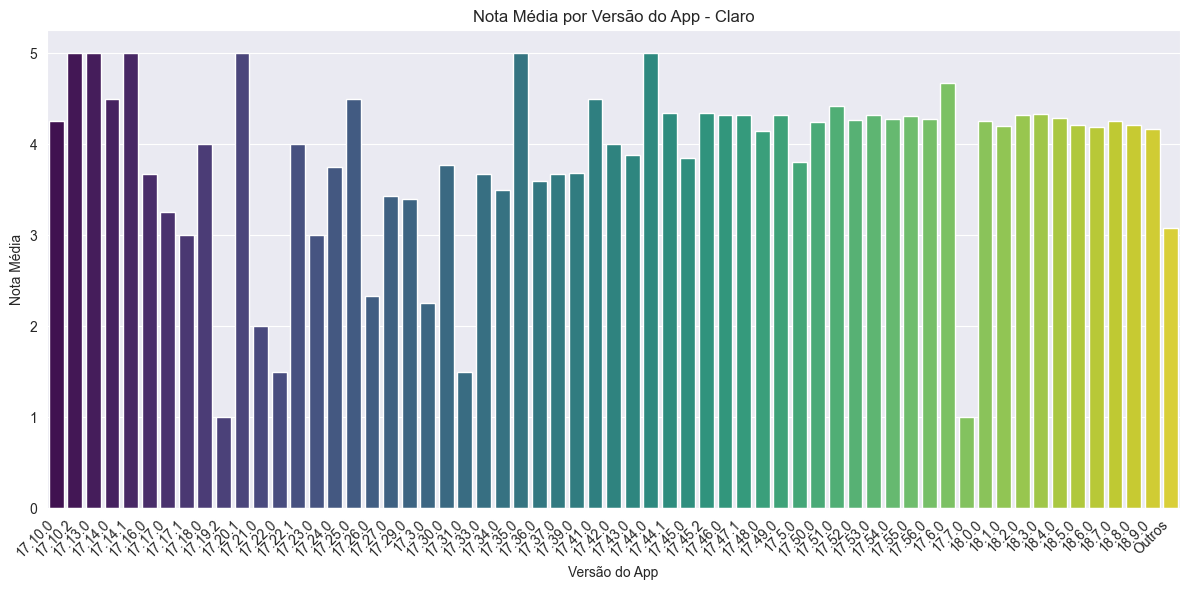

In [31]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gr√°fico de barras da nota m√©dia por vers√£o
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualiza√ß√£o
plt.xlabel('Vers√£o do App')
plt.ylabel('Nota M√©dia')
plt.title('Nota M√©dia por Vers√£o do App - Claro')
plt.tight_layout()
plt.show()


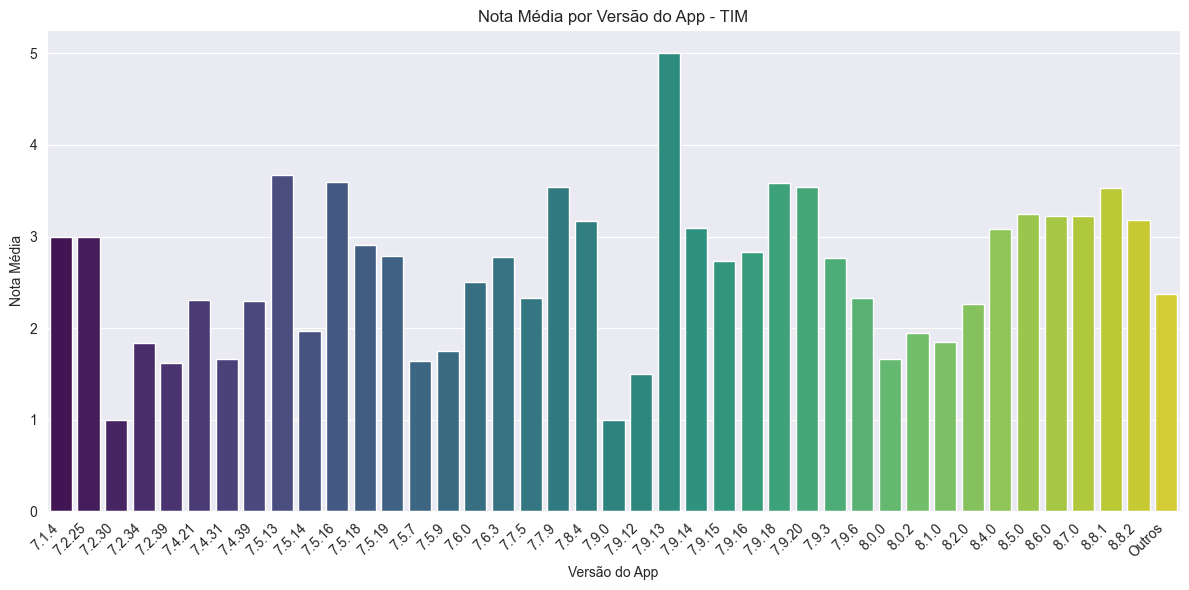

In [32]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gr√°fico de barras da nota m√©dia por vers√£o
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualiza√ß√£o
plt.xlabel('Vers√£o do App')
plt.ylabel('Nota M√©dia')
plt.title('Nota M√©dia por Vers√£o do App - TIM')
plt.tight_layout()
plt.show()

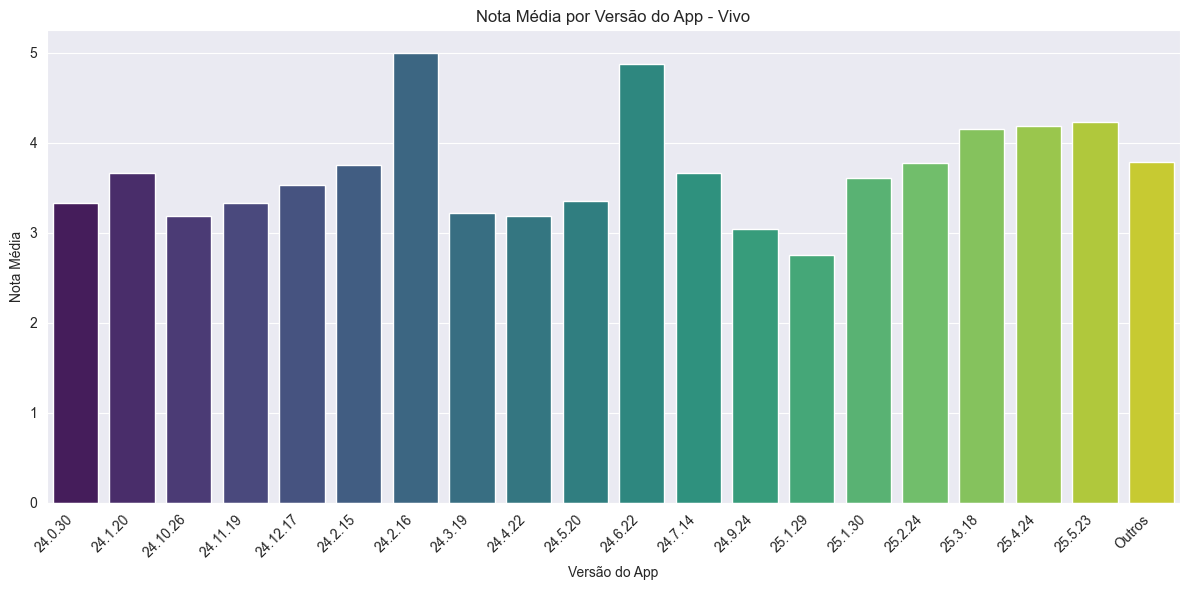

In [33]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

media_por_versao = resultado.groupby('app_version_agrupada')['score'].mean().reset_index()

# 4. Gr√°fico de barras da nota m√©dia por vers√£o
plt.figure(figsize=(12,6))
sns.barplot(data=media_por_versao, x='app_version_agrupada', y='score', palette='viridis')

plt.xticks(rotation=45, ha='right')  # gira as labels para melhor visualiza√ß√£o
plt.xlabel('Vers√£o do App')
plt.ylabel('Nota M√©dia')
plt.title('Nota M√©dia por Vers√£o do App - Vivo')
plt.tight_layout()
plt.show()

### Sentimentos por Vers√£o
- Os apps lan√ßam muitas vers√£o intermedi√°rias, que dificutam uma an√°lise mais aprofundada a partir dos coment√°rios. Nesse caso, n√£o foi t√£o relevante assim.

#### Claro

In [34]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('17.0.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Claro'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada  17.10.0  17.10.2  17.13.0  17.14.0  17.14.1  17.16.0  \
sentiment_output                                                             
NEG                       0.0      0.0      0.0      0.0      0.0      1.0   
NEU                       2.0      1.0      1.0      2.0      3.0      1.0   
POS                       2.0      2.0      0.0      2.0      0.0      1.0   

app_version_agrupada  17.17.0  17.17.1  17.18.0  17.19.2  17.20.1  17.21.0  \
sentiment_output                                                             
NEG                       2.0      1.0      0.0      0.0      0.0      2.0   
NEU                       1.0      1.0      3.0      1.0      2.0      2.0   
POS                       1.0      0.0      1.0      0.0      3.0      0.0   

app_version_agrupada  17.22.0  17.22.1  17.23.0  17.24.0  17.25.0  17.26.0  \
sentiment_output                                                             
NEG                       2.0      0.0      1.0      0.0      0.0      1.0   
NEU                       0.0      2.0      0.0      3.0      2.0      2.0   
POS                       0.0      2.0      0.0      0.0      0.0      0.0   

app_version_agrupada  17.27.0  17.29.0  17.3.0  17.30.0  17.31.0  17.33.0  \
sentiment_output                                                            
NEG                       2.0      1.0     3.0      2.0      0.0      2.0   
NEU                       3.0      3.0     0.0      8.0      2.0      7.0   
POS                       2.0      1.0     1.0      3.0      0.0      3.0   

app_version_agrupada  17.34.0  17.35.0  17.36.0  17.37.0  17.39.0  17.41.0  \
sentiment_output                                                             
NEG                       2.0      0.0      2.0      7.0      6.0      0.0   
NEU                       1.0      1.0      2.0      9.0     11.0      0.0   
POS                       1.0      0.0      1.0      5.0      2.0      2.0   

app_version_agrupada  17.42.0  17.43.0  17.44.0  17.44.1  17.45.0  17.45.2  \
sentiment_output                                                             
NEG                       3.0      9.0      0.0     81.0     11.0     40.0   
NEU                       7.0     23.0      2.0    332.0     17.0    173.0   
POS                       3.0     11.0      1.0    266.0     26.0    130.0   

app_version_agrupada  17.46.0  17.47.1  17.48.0  17.49.0  17.5.0  17.50.0  \
sentiment_output                                                            
NEG                      43.0    137.0    189.0    105.0     1.0     59.0   
NEU                     192.0    518.0    522.0    419.0     3.0    209.0   
POS                     161.0    425.0    356.0    317.0     1.0    169.0   

app_version_agrupada  17.51.0  17.52.0  17.53.0  17.54.0  17.55.0  17.56.0  \
sentiment_output                                                             
NEG                      19.0     61.0     79.0    188.0     59.0    138.0   
NEU                      88.0    226.0    325.0    637.0    176.0    432.0   
POS                      71.0    182.0    193.0    495.0    138.0    367.0   

app_version_agrupada  17.6.0  17.7.0  18.0.0  18.1.0  18.2.0  18.3.0  18.4.0  \
sentiment_output                                                               
NEG                      0.0     1.0    86.0    24.0    41.0    75.0   124.0   
NEU                      2.0     0.0   325.0    74.0   171.0   275.0   460.0   
POS                      1.0     0.0   237.0    48.0   114.0   206.0   348.0   

app_version_agrupada  18.5.0  18.6.0  18.7.0  18.8.0  18.9.0  Outros  
sentiment_output                                                      
NEG                    121.0    71.0    41.0    71.0     3.0   400.0  
NEU                    365.0   269.0   134.0   315.0    18.0   456.0  
POS                    298.0   178.0    95.0   189.0     9.0   254.0

In [35]:
frequencias = df[df['app'] == 'Claro']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Claro']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada  17.44.1  17.45.2  17.46.0  17.47.1  17.48.0  17.49.0  \
sentiment_output                                                             
NEG                        81       40       43      137      189      105   
NEU                       332      173      192      518      522      419   
POS                       266      130      161      425      356      317   

app_version_agrupada  17.50.0  17.52.0  17.53.0  17.54.0  17.55.0  17.56.0  \
sentiment_output                                                             
NEG                        59       61       79      188       59      138   
NEU                       209      226      325      637      176      432   
POS                       169      182      193      495      138      367   

app_version_agrupada  18.0.0  18.2.0  18.3.0  18.4.0  18.5.0  18.6.0  18.7.0  \
sentiment_output                                                               
NEG                       86      41      75     124     121      71      41   
NEU                      325     171     275     460     365     269     134   
POS                      237     114     206     348     298     178      95   

app_version_agrupada  18.8.0  Outros  
sentiment_output                      
NEG                       71     167  
NEU                      315     353  
POS                      189     234

#### TIM

In [36]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('7.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'TIM'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada  7.1.4  7.2.25  7.2.30  7.2.34  7.2.39  7.4.21  7.4.31  \
sentiment_output                                                              
NEG                     4.0     2.0     1.0     6.0     2.0     5.0    15.0   
NEU                     3.0     1.0     0.0     6.0     5.0     6.0     5.0   
POS                     3.0     1.0     0.0     0.0     1.0     2.0     1.0   

app_version_agrupada  7.4.39  7.5.13  7.5.14  7.5.16  7.5.18  7.5.19  7.5.7  \
sentiment_output                                                              
NEG                     17.0     1.0    19.0     2.0     9.0    11.0    6.0   
NEU                      6.0     3.0    13.0     1.0     9.0    12.0    3.0   
POS                      6.0     2.0     1.0     2.0     3.0     4.0    2.0   

app_version_agrupada  7.5.9  7.6.0  7.6.3  7.7.5  7.7.9  7.8.4  7.9.0  7.9.12  \
sentiment_output                                                                
NEG                    35.0   13.0    6.0    3.0    3.0    7.0    0.0     0.0   
NEU                    12.0    6.0   12.0    1.0    6.0   13.0    1.0     2.0   
POS                     4.0    3.0    3.0    2.0    2.0    4.0    0.0     0.0   

app_version_agrupada  7.9.13  7.9.14  7.9.15  7.9.16  7.9.18  7.9.20  7.9.3  \
sentiment_output                                                              
NEG                      0.0     3.0    31.0   277.0   312.0   508.0   46.0   
NEU                      0.0     5.0    31.0   316.0   501.0   784.0   40.0   
POS                      1.0     3.0    14.0   104.0   279.0   436.0   19.0   

app_version_agrupada  7.9.6  8.0.0   8.0.2  8.1.0  8.2.0  8.4.0  8.5.0  8.6.0  \
sentiment_output                                                                
NEG                     2.0    4.0  1127.0  559.0  955.0  310.0  196.0  490.0   
NEU                     0.0    2.0   512.0  250.0  641.0  281.0  224.0  681.0   
POS                     1.0    0.0   147.0   60.0  174.0  158.0  102.0  323.0   

app_version_agrupada  8.7.0  8.8.1  8.8.2  Outros  
sentiment_output                                   
NEG                   294.0   91.0    5.0  1277.0  
NEU                   332.0  186.0    5.0   898.0  
POS                   203.0   66.0    1.0   316.0

In [37]:
frequencias = df[df['app'] == 'TIM']['app_version'].value_counts()

limiar = 200
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'TIM']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada  7.9.16  7.9.18  7.9.20  8.0.2  8.1.0  8.2.0  8.4.0  \
sentiment_output                                                           
NEG                      277     312     508   1127    559    955    310   
NEU                      316     501     784    512    250    641    281   
POS                      104     279     436    147     60    174    158   

app_version_agrupada  8.5.0  8.6.0  8.7.0  8.8.1  Outros  
sentiment_output                                          
NEG                     196    490    294     91     433  
NEU                     224    681    332    186     317  
POS                     102    323    203     66     128

#### Vivo

In [38]:
def agrupa_versao(v):
    if pd.isnull(v):
        return 'Outros'
    try:
        return v if parse(str(v)) >= parse('20.0') else 'Outros'
    except:
        return 'Outros'

resultado = df[df['app'] == 'Vivo'].copy()
resultado['app_version'] = resultado['app_version'].fillna('0')
resultado['app_version_agrupada'] = resultado['app_version'].apply(agrupa_versao)

resultado_grouped = (resultado
                     .groupby(['sentiment_output', 'app_version_agrupada'])
                     .size()
                     .reset_index(name='contagem'))

tabela = resultado_grouped.pivot(index='sentiment_output',
                                 columns='app_version_agrupada',
                                 values='contagem').fillna(0)

tabela

app_version_agrupada  24.0.30  24.1.20  24.10.26  24.11.19  24.12.17  24.2.15  \
sentiment_output                                                                
NEG                       1.0      1.0       8.0      12.0      10.0      0.0   
NEU                       4.0      2.0       8.0      15.0      19.0      1.0   
POS                       1.0      0.0       0.0       4.0       7.0      3.0   

app_version_agrupada  24.2.16  24.3.19  24.4.22  24.5.20  24.6.22  24.7.14  \
sentiment_output                                                             
NEG                       0.0      2.0      1.0      4.0      0.0      6.0   
NEU                       1.0      6.0      5.0      7.0      6.0      7.0   
POS                       1.0      1.0      4.0      3.0      1.0      2.0   

app_version_agrupada  24.9.24  25.1.29  25.1.30  25.2.24  25.3.18  25.4.24  \
sentiment_output                                                             
NEG                      11.0      1.0     28.0     44.0    792.0    550.0   
NEU                      10.0      3.0     55.0     83.0   2483.0   1916.0   
POS                       6.0      0.0     25.0     54.0   1516.0   1225.0   

app_version_agrupada  25.5.23  Outros  
sentiment_output                       
NEG                     538.0   486.0  
NEU                    1985.0   999.0  
POS                    1317.0   587.0

In [39]:
frequencias = df[df['app'] == 'Vivo']['app_version'].value_counts()

limiar = 50
versoes_rare = frequencias[frequencias < limiar].index

df['app_version_agrupada'] = df['app_version'].where(~df['app_version'].isin(versoes_rare), 'Outros')

resultado = (df[df['app'] == 'Vivo']
             .groupby(['sentiment_output', 'app_version_agrupada'])
             .size()
             .reset_index(name='contagem'))

tabela = resultado.pivot(index='sentiment_output', columns='app_version_agrupada', values='contagem').fillna(0)
tabela


app_version_agrupada  25.1.30  25.2.24  25.3.18  25.4.24  25.5.23  Outros
sentiment_output                                                         
NEG                        28       44      792      550      538     116
NEU                        55       83     2483     1916     1985     159
POS                        25       54     1516     1225     1317      74

### Sentimentos

Nesse primeiro gr√°fico, apenas substitui o nome original para um nome mais vis√≠vel

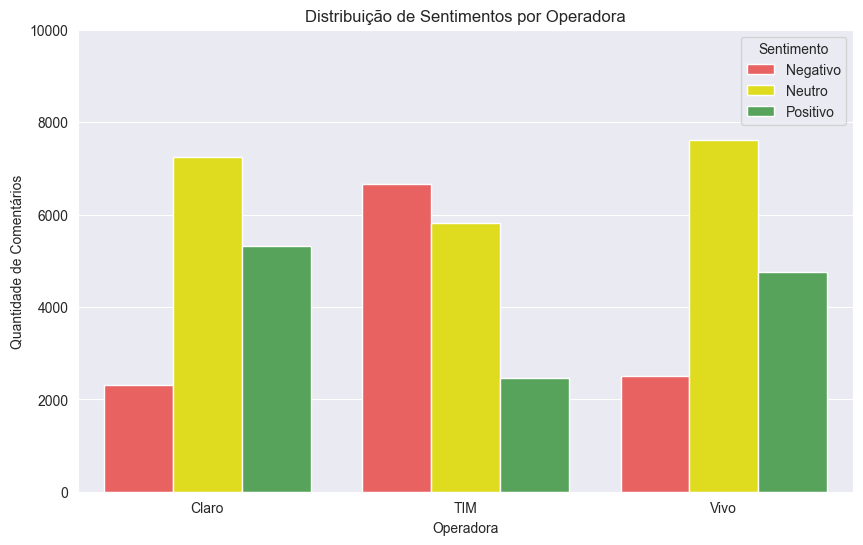

In [76]:
def map_sentiment(sent):
    if sent in ['NEG', 'negativo']:
        return 'Negativo'
    elif sent in ['NEU', 'neutro']:
        return 'Neutro'
    elif sent in ['POS', 'positivo']:
        return 'Positivo'
    else:
        return 'Outro'

df['sentimento_simplificado'] = df['sentiment_output'].apply(map_sentiment)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribui√ß√£o de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Coment√°rios")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()


Tamb√©m investiguei os coment√°rios comentados como **Neutros**, pela sua alta quantidade, encontrei diversos coment√°rios compostos de de frases curtas ou de uma ou duas palavras que foram classificados como neutros, mas poderiam ser possitivos ou negativos. \

Nesse caso, al√©m do tratamento do nome, realizei um teste para manter apenas como neutros apenas os coment√°rios que tinha a probabilidade acima 70% de serem neutros. Os coment√°rios que eram netruos e abaixo de 70%, foram reclassificados com o segundo sentimento mais prov√°vel, positivo ou negativo.
Ap√≥s essa reclassifica√ß√£o, houve um crescimento maior de sentimentos positivos para a Claro e a Vivo, enquanto cresceu mais os sentimento negativos para a TIM.


In [80]:
#Exemplo de alguns comentarios classificados como neutros e que poderiam estar em outra classifica√ß√£o
df[(df["sentiment_output"] == "NEU") & (df["sentiment_NEU"] < 0.5)][['content', 'content_proc', 'sentiment_output']].head()

content  \
107                                                  ü§¨   
139                                             gostei   
276  ia fechar um plano p√≥s, vendedora atendeu mal ...   
330                                     estou gostando   
332                                    An√∫ncios demais   

                                          content_proc sentiment_output  
107                               rostocoms√≠mbolosnabo              NEU  
139                                             gostar              NEU  
276  fechar plano p√≥s vendedor atender mal desistir...              NEU  
330                                             gostar              NEU  
332                                     an√∫ncio demais              NEU

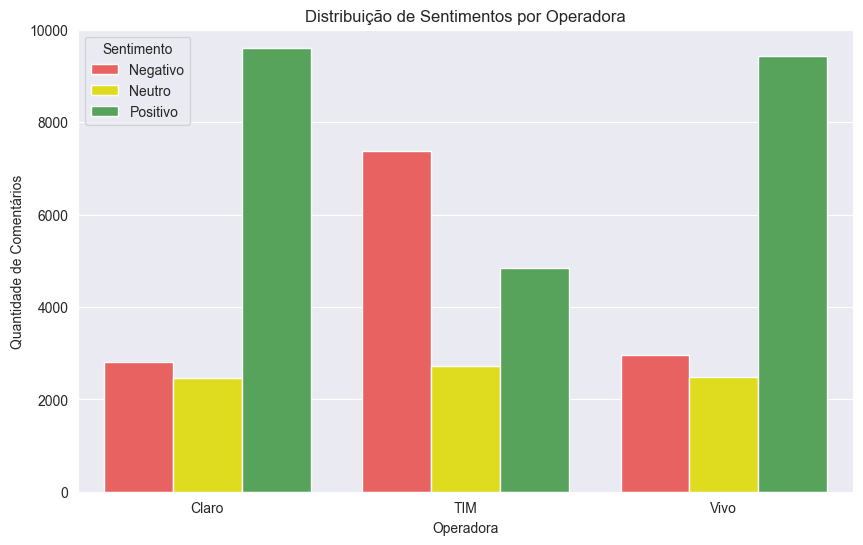

In [77]:
def map_sentiment(row, limiar_neu=0.7):
    sentiment = row.get('sentiment_output', '')
    if sentiment == 'NEG':
        return 'Negativo'
    elif sentiment == 'POS':
        return 'Positivo'
    elif sentiment == 'NEU':
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= limiar_neu:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment

df['sentimento_simplificado'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_simplificado',
    palette={'Negativo': '#FF4C4C', 'Neutro': '#FFFB00', 'Positivo': '#4CAF50'},
    hue_order=['Negativo', 'Neutro', 'Positivo']
)

plt.title("Distribui√ß√£o de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Coment√°rios")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

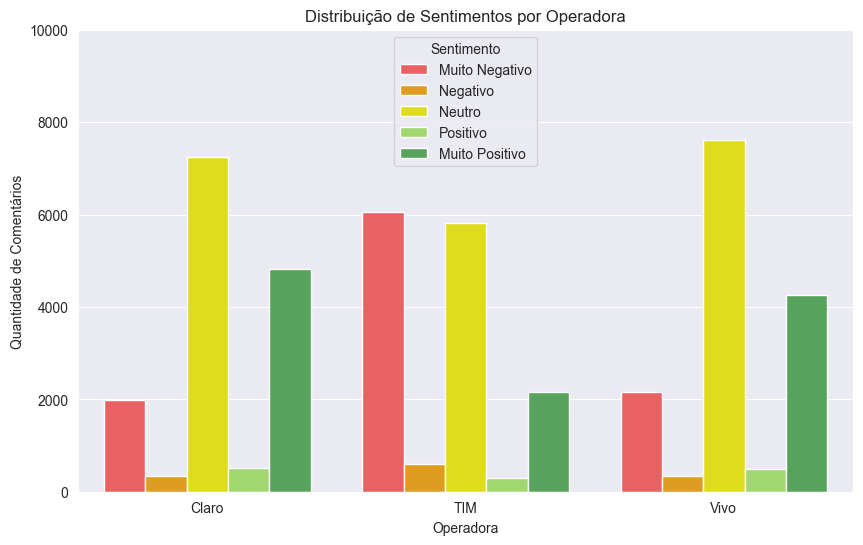

In [8]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.7:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.7:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        return "Neutro"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribui√ß√£o de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Coment√°rios")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

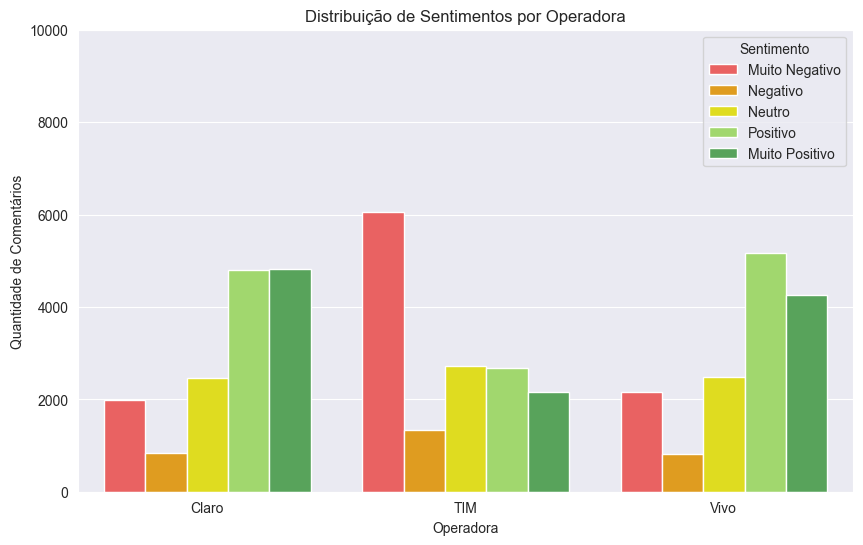

In [6]:
def map_sentiment(row):
    sentiment = row['sentiment_output']
    if sentiment == "NEG":
        prob = row.get('sentiment_NEG', 0)
        if prob < 0.7:
            return "Negativo"
        else:
            return "Muito Negativo"
    elif sentiment == "POS":
        prob = row.get('sentiment_POS', 0)
        if prob < 0.7:
            return "Positivo"
        else:
            return "Muito Positivo"
    elif sentiment == "NEU":
        prob_pos = row.get('sentiment_POS', 0)
        prob_neu = row.get('sentiment_NEU', 0)
        prob_neg = row.get('sentiment_NEG', 0)
        if prob_neu >= 0.7:
            return "Neutro"
        return "Positivo" if prob_pos > prob_neg else "Negativo"
    else:
        return sentiment
df['sentimento_complexo'] = df.apply(map_sentiment, axis=1)

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='app',
    hue='sentimento_complexo',
    palette={'Muito Negativo': '#FF4C4C', 'Negativo': '#FFA500', 'Neutro': "#FFFB00",
             'Positivo': "#A0E95C", 'Muito Positivo': '#4CAF50'},
    hue_order=['Muito Negativo', 'Negativo', 'Neutro', 'Positivo', 'Muito Positivo']
)

plt.title("Distribui√ß√£o de Sentimentos por Operadora", loc="center")
plt.xlabel("Operadora")
plt.ylabel("Quantidade de Coment√°rios")
plt.ylim(0, 10000)
plt.legend(title="Sentimento")

plt.show()

In [11]:
values_claro = df[df['app'] == 'Claro'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_tim = df[df['app'] == 'TIM'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

values_vivo = df[df['app'] == 'Vivo'][['emotion_alegria', 'emotion_tristeza', 'emotion_raiva',
              'emotion_medo', 'emotion_surpresa', 'emotion_confianca',
              'emotion_confusao', 'emotion_neutro']].mean().tolist()

categories = ['Alegria', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Confian√ßa', 'Confus√£o', 'Neutro']

# Valores de exemplo para cada operadora
values_vivo = values_vivo
values_tim = values_tim
values_claro = values_claro

# Criar subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]]
)

# Gr√°fico Vivo
fig.add_trace(go.Scatterpolar(
    r=values_vivo,
    theta=categories,
    fill='toself',
    name='Vivo',
    line=dict(color='purple'),
    opacity=0.7
), row=1, col=1)

# Gr√°fico TIM
fig.add_trace(go.Scatterpolar(
    r=values_tim,
    theta=categories,
    fill='toself',
    name='TIM',
    line=dict(color='royalblue'),
    opacity=0.7
), row=1, col=2)

# Gr√°fico Claro
fig.add_trace(go.Scatterpolar(
    r=values_claro,
    theta=categories,
    fill='toself',
    name='Claro',
    line=dict(color='red'),
    opacity=0.7
), row=1, col=3)

# Ajustar o layout geral
fig.update_layout(
    showlegend=False,
    title_text="Distribui√ß√£o de Emo√ß√µes por Operadora",
    height=650, width=1800,
)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=False)),
    polar2=dict(radialaxis=dict(visible=False)),
    polar3=dict(radialaxis=dict(visible=False))
)


# Ajuste do posicionamento dos t√≠tulos: mais para cima
fig.add_annotation(dict(font=dict(size=16),
                        x=0.13,
                        y=1.1,
                        showarrow=False,
                        text="Vivo",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.5,
                        y=1.1,
                        showarrow=False,
                        text="TIM",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(size=16),
                        x=0.87,
                        y=1.1,
                        showarrow=False,
                        text="Claro",
                        xref="paper",
                        yref="paper"))

fig.show()

---
# Classifica√ß√£o de Temas
Nessa se√ß√£o, o objetivo principal √© classificar os principais temas comentados, de maneira manual, e entender o sentimento m√©dio sobre os temas. Aproveitando a aplica√ß√£o dos modelos de sentimentos e emo√ß√µes aos coment√°rios, com suas probabilidades.

**Insights** \
Numa vis√£o consolidada, as tr√™s operadoras tiveram um desempenho semelhante nos temas classificados. As tr√™s n√£o tiveram sentimentos positivos em nenhum tema, apenas sentimentos que tendem a serem negativos. \

**Claro** \
Entre os 10 temas catalogados, **Operadora** e **App** tiveram um sentimento neutro, **Plano**, **Internet**, **Atendimento** e **Conta** foram um pouco negativo, e **Usuabilidade**, **Login**, **Desempenho** e **Notifica√ß√µes** foram negativos.
- Quando buscam atendimento via aplicativo, usu√°rios t√™m dificuldades para se manter no chat ou ter retorno de solicita√ß√µes abertas.
- Relacionado com o atendimento, usu√°rios comentaram sobre faturas que j√° foram pagas sendo cobradas novamente ou que n√£o aparece a fatura para pagar.
- Existe sentimentos mistos relacionados a recargas e a velocidade da internet.
- Usu√°rios reportam muitos erros ao tentar logar no app, com tentativa de login manual ou reconhecimento de chip.
- Usu√°rios apotam sobre o uso alto de propagandas feitas dentro do app, sms e outras formas que incomodam no dia a dia. Alguns apontam que chega afetar o desempenho do app com a publicidade apresentada.

**TIM** \
A TIM tem um comportamento distinto da Claro, os 10 temas ficaram como negativos e tiveram muitos coment√°rios sobre **Operadora** e **App**.
- Os usu√°rios da TIM apontam problemas estruturais do app em diversas √°reas, em internet, erros, login, benef√≠cios e etc. Parece o caso de erros nas vers√µes mais recentes que precisam de corre√ß√µes imediatas.
- Como os sentimentos s√£o mais negativos no geral, esses problemas acabam generalizando para todos os temas classificados.

**Vivo** \
A Vivo tem um comporamento semelhante com a Claro com as categorias sobre **Operadora** e **App**, sendo os temas com sentimentos mais medianos entre os 10 classificados. Tamb√©m se reflete nos demais temas, com **Plano**, **Internet**, **Atendimento** e **Conta** com sentimentos um pouco negativos, e **Usuabilidade**, **Login**, **Desempenho** e **Notifica√ß√µes** com sentimento negativos.
- Os problemas apontados s√£o bastante semelhantes aos apontados para o app da Claro e da TIM.

## Aplica√ß√µes gerais
Na c√©lula abaixo √© removido os poucos coment√°rios que n√£o foiram poss√≠veis serem trados e ficaram vazios \
Aplica√ß√£o da classifica√ß√£o manual dos temas, buscando nos coment√°rios as palavras selecionadas e agrupando em temas gerais \
E o c√°lculo por linha, utilizando as probabilidades de sentimento, para verificar um sentimento m√©dio.

In [53]:
df.dropna(subset="content_proc", inplace=True)

df['tema_manual'] = df['content_proc'].swifter.apply(lambda x: classificar_tema(x, temas_manuais))

df_explodido = df.explode('tema_manual').dropna(subset=['tema_manual'])

df_explodido['sentimento_continuo'] = (
    df_explodido['sentiment_POS'] * 1 +
    df_explodido['sentiment_NEU'] * 0 +
    df_explodido['sentiment_NEG'] * -1
)

Pandas Apply: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 44671/44671 [00:02<00:00, 18384.03it/s]


**Gr√°fico Operadoras**

In [ ]:
df['tema_manual_abreviado'] = df['content_proc'].swifter.apply(lambda x: classificar_tema(x, temas_manuais_abrevidado))
df_explodido_geral = df.explode('tema_manual_abreviado').dropna(subset=['tema_manual_abreviado'])

df_explodido_geral['sentimento_continuo'] = (
    df_explodido_geral['sentiment_POS'] * 1 +
    df_explodido_geral['sentiment_NEU'] * 0 +
    df_explodido_geral['sentiment_NEG'] * -1
)

#Agrupamento por tema
df_tema = df_explodido_geral.groupby(['app', 'tema_manual_abreviado']).agg(
    volume=('tema_manual_abreviado', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gr√°fico
df_tema['tamanho'] = df_tema['volume'] * 20

In [ ]:
fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    symbol='app',
    text="tema_manual_abreviado",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 5000],
    title="<b>Temas + Falados - Operadoras</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Coment√°rios",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    },
    legend_title_text='Operadora',
    legend=dict(
        orientation="v",
        yanchor="bottom",
        y=0.835,
        xanchor="center",
        x=0.075,
        font=dict(size=12))
)

fig.show()

In [ ]:
fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    symbol='app',
    text="tema_manual_abreviado",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-0.8, 0.2],
    range_x=[-200, 2400],
    title="<b>Temas + Falados - Operadoras</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Coment√°rios",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    },
    legend_title_text='Operadora',
    legend=dict(
        orientation="v",
        yanchor="bottom",
        y=0.835,
        xanchor="center",
        x=0.075,
        font=dict(size=12))
)

fig.show()

## Claro

In [26]:
df_claro = df_explodido[df_explodido["app"] == "Claro"]

#Agrupamento por tema
df_tema = df_claro.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gr√°fico
df_tema['tamanho'] = df_tema['volume'] * 20

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados - Claro</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Coment√°rios",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [42]:
#Sentimento Negativo
operadora = df["app"]=="Claro"
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Desempenho" in x)
sentimento = df["sentiment_NEG"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_NEG"]].head(15)

content  \
15                                                                                                                                                                                                                                                                                                                    A atualiza√ß√£o estou dazerdo agora n√£o vou opinar. mas os servi√ßos da Claro foram nota zero, de claro n√£o tem nada.   
21                                                                                                                                                                                                                                                                                                                                                                                        n√£o t√¥ conseguindo acessar o app t√° dando erro   
37                                                                                                                                                                                                                                                                                                                                                                                                        ruim, apresenta erro direto...   
53   inadmiss√≠vel o servi√ßo da Claro p√©ssimo. a light retira um poste e causa a ruptura do meu servi√ßo de internet e tv a cabo , e j√° s√£o uma semana , a cada dia d√£o. parecer diferente , n√£o d√£o a op√ß√£o de um t√©cnico para vir resolver o problema. dizem que est√° resolvendo e √© enganoso a informa√ß√£o. pois j√° vai para uma semana . essa empresa n√£o cumpre com sua palavra . uma vergonha. a Net era muito melhor que a claro n√£o   
91                                                                                            Claro -Bauru sp perturbando com liga√ß√µes indesejadas. Burlando o sistema do "n√£o me pertuebe " Internet lenta, r√°pida s√≥ no consumo . YouTube consumindo toda Internet. Prez√£o YouTube 3Gb, somente para "devorar" sua Internet. A operadora claro continua devorando Internet dos clientes atrav√©s desse YouTube 3gb. Claro papa internet   
105                                                                                                                                                                                                                                                                      Experi√™ncia muito ruim, √© muito lento o meu wi -fi . No aplicativo aparece tudo bem, mas continua travando e o pior , para solicitar o t√©cnico, preciso pagar .   
106                                                                                                                                                                                                                                                                                                  O APP est√° travando na tela da promo√ß√£o impedindo que consiga fazer a recarga. J√° atualizei, reinstalei e cont√≠nua dando este erro.   
142                                                                                                                                                                             Aplicativo lento e ultrapassado, mas o pior √© a postura da operadora que envia mensagem que ir√° cortar linha sendo que fatura est√° paga, inclusive com tal informa√ß√£o j√° no aplicativo. A postura inaceit√°vel me levou a fazer portabilidade para a TIM.   
161                                                                                                                                                                                                                                                                                                       o app est√° bugando, est√° horr√≠vel, coloco login e senha e fica girando e n√£o sai disso, n√£o consigo ter acesso ao app. p√©ssimo   
166                                                                               

In [43]:
#Sentimento Positivo
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Desempenho" in x)
sentimento = df["sentiment_POS"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_POS"]].head(15)

content  \
648                                                                                                                                                                                  o aplicativo e √≥timo,n√£o trava e super √°gil e facil de usar   
681                                                                                                                                                                                         Excelente aplicativo. Melhorando a cada atualiza√ß√£o.   
1183                                                                                                                                                                                              muito bom o aplicativo resolve meus problemas.   
1382                             o aplicativo √© incr√≠vel mas as vezes ocorre um tipo de instabilidade para acessar automaticamente com a rede da Claro mas tirando isso √© incr√≠vel voc√™ consegue saber tudo da sua linha e acompanhar o consumo.   
1471                                                                                                                                                                                     perfeito para o Meu Uso sem Problemas Celular Wi-Fi TV.   
1513                                                                                                                                                   excelente;o app √© muito r√°pido e a solu√ß√£o de qualquer problema √© resolvido de imediato .   
1806  √≥timo aplicativo mais toda vez que vou pagar a fatura pede cart√£o de cr√©dito eu sempre pago via Pix e outro problema n√£o est√° aparecendo a op√ß√£o de fatura para pagar a claro √© uma excelente operadora mais v√™ se resolve esses problemas   
2019                                                                                                                                                √≥timo servi√ßo mas travou n√£o consegui atualizar n√∫mero de celular novo em uma op√ß√£o do App .   
2023                                                                                                                                                                 O app √© √≥timo,fa√ßo meus pagamentos todo m√™s sem ter nenhum ripo de problema   
2380                                                cancelei uma visita t√©cnica sem problemas e bem rapido. inesperadamente chegaram visitas em minha casa e precisava dar aten√ß√£o. parab√©ns pela agilidade do servi√ßo claronet. me surpreendeu.   
2721                                                                                                                                                                                               melhor que na atualiza√ß√£o passada, melhoraram   
2748                                                                             Sou Cliente Claro a 20 anos e n√£o tenho do que reclamar! Estou satisfeita com os servi√ßos oferecidos,nunca tive problemas com faturas ou outros tipos! Parab√©ns   
4678                                                                                                                                                                                               As atualiza√ß√µes est√£o sendo bem satisfat√≥rias   
4969                                                                           Aplicativo bem intuitivo, consigo resolver todos meus problemas por ele, de uma forma r√°pida e pr√°tica! Recomendo usarem, da para resolver at√© pagamento por ele.   
5419                                                                                                                                                                  Melhorou bastante nas √∫ltimas atualiza√ß√µes. Os t√©cnicos est√£o de parab√©ns!   

      sentiment_POS  
648        0.988951  
681        0.992432  
1183       0.839797  
1382       0.965163  
1471       0.989365  
1513       0.989202  
1806       0.946404  
2019       0.916730  
2023       0.969830  
2380       0.947605  
2721       0.979225  
2748   

## TIM

In [15]:
df_tim = df_explodido[df_explodido["app"] == "TIM"]

#Agrupamento por tema
df_tema = df_tim.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gr√°fico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necess√°rio

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 5000],
    title="<b>Temas + Falados - TIM</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Coment√°rios",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [18]:
df_tim = df_explodido[df_explodido["app"] == "TIM"]

#Agrupamento por tema
df_tema = df_tim.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gr√°fico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necess√°rio

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados - TIM (s/ Operadora, App e Desempenho)</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Coment√°rios",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [49]:
#Sentimento Negativo
operadora = df["app"]=="TIM"
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Atendimento" in x)
sentimento = df["sentiment_NEG"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_NEG"]].head(15)

content  \
15001                                                                                                                                                                                                                                                                                                                                                                                                                                                                       empresa p√©ssima em rela√ß√£o ao atendimento   
15017                                                                                                                                                                                                                                                                                                                                                                                   Quer mudar o plano da OI Fixo para portabilidade TIM fuxo e n√£o consigo falar com ningu√©m. O atendimento digital √© irritante.   
15040                                                                                                                                                                                                                           A operadora de plano mais caro que j√° vi. J√° tentei cancelar meu plano e n√£o consigo . Oferecem um plano caro, com dados m√≥veis que praticamente n√£o pegam em lugar nenhum. E o atendimento pela operadora √© p√©ssimo e ainda deixa a gente sem resposta e sem solu√ß√£o para o problema   
15094                                                                                                                                                                                                                                                                                                      P√©ssimo. Fiz a portabilidade da Claro para Tim a 2 meses e at√© agora n√£o consegui usar, fechei um plano para usar benef√≠cios e nada. Via telefone n√£o consigo atendimento e j√° tenho 3 protocolos da loja.   
15185                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    p√©ssimo atendimento horr√≠vel   
15248                                                                                                                    Meu plano era 80gb, baixaram em menos de 1 ano para 76gb e agora mudaram meu plano para 15gb. Aumentaram o valor do plano em menos de 1 ano, voc√™ n√£o pode mandar √°udio, nem imagem comprovando, atendente humana n√£o aparece, desligam na sua cara... Eu tou passando mal aqui... DESCASO TOTAL com o cliente, quero cancelar wifi e 4g dessa operadora diab√≥lica üò°... N√ÉO ENTREM √â FURADA!   
15263                                                                                                                                                                                                                                                                                                                                                                                                  Pior operadora, s√≥ uso porque a √∫nica que pega na regi√£o em que moro hje. SINAL horr√≠vel, atendimento p√©ssimo.   
15361                                                                                                                                                                                                                                                                                     se tornou o pior atendimento de todos uma grande vergonha p√©ssima operadora, quando renova a internet o sinal some , trinta dias de u

In [48]:
#Sentimento Positivo
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Atendimento" in x)
sentimento = df["sentiment_POS"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_POS"]].head(15)

content  \
15002                                                quase o melhor atendimento falta s√≥ menos an√∫ncios   
15020                                                                        Bom servi√ßo de atendimento   
15089                                                                                   bom atendimento   
15368                                                                                Atendimento √≠mpar.   
15921                                                                       Bom atendimento muito bom üëç   
16175  Nada a reclamar. A Tim tem me dado bastante benef√≠cios. Atendimento r√°pido e eficaz! App eficaz.   
16294                                                                      Gostei muito do atendimento.   
16321                                                                      √≥tima o atendimento obrigado   
16562                                                                       o atendimento pessoal √© bom   
16747      Gostei bastante,mas o atendimento ao cliente √© demorado para falar com um dos atende dentes.   
16920                                             √ìtimo atendimento e muito boas as op√ß√µes de pagamento   
17131                                               eu s√≥ tenho que agradecer a Tim por bom atendimento   
17271                                                                    otima ou MUITO bom atendimento   
17407                                                                                 √≥timo atendimento   
17430                                                                         parab√©ns belo atendimento   

       sentiment_POS  
15002       0.953299  
15020       0.981695  
15089       0.969055  
15368       0.990155  
15921       0.939548  
16175       0.979279  
16294       0.978974  
16321       0.982661  
16562       0.986668  
16747       0.806056  
16920       0.931763  
17131       0.947490  
17271       0.986618  
17407       0.969055  
17430       0.990095

## Vivo

In [21]:
df_vivo = df_explodido[df_explodido["app"] == "Vivo"]

#Agrupamento por tema
df_tema = df_vivo.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gr√°fico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necess√°rio

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 3000],
    title="<b>Temas + Falados - Vivo</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Coment√°rios",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [22]:
df_vivo = df_explodido[df_explodido["app"] == "Vivo"]

#Agrupamento por tema
df_tema = df_vivo.groupby('tema_manual').agg(
    volume=('tema_manual', 'count'),
    sentimento_medio=('sentimento_continuo', 'mean')
).reset_index()

# Normaliza o volume para tamanho dos pontos no gr√°fico
df_tema['tamanho'] = df_tema['volume'] * 20  # Ajuste conforme necess√°rio

fig = px.scatter(
    df_tema,
    x="volume",
    y="sentimento_medio",
    size="tamanho",
    color="sentimento_medio",
    text="tema_manual",
    color_continuous_scale= ["#F74A4A", '#FFFB00', '#4CAF50'],
    range_y=[-1, 1],
    range_x=[-200, 2500],
    title="<b>Temas + Falados - Vivo (s/ App)</b>"
)

# Ajustes visuais
fig.update_traces(textposition='top center')
fig.update_layout(
    width=700,
    height=700,
    xaxis_title="Qtd Coment√°rios",
    yaxis_title="Sentimento",
    coloraxis_colorbar=dict(title="Sentimento"),
    coloraxis=dict(cmin=-1, cmax=1),
    template="seaborn",
    title={'font':{
            'size': 24,
            'family': 'Arial'},
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.9,
    }
)

fig.show()

In [54]:
#Sentimento Negativo
operadora = df["app"]=="Vivo"
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Desempenho" in x)
sentimento = df["sentiment_NEG"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_NEG"]].head(15)

content  \
30055                                                                                                                                                                                                                                                                                                                                                                                                                                                         p√©ssima. o app √© lento e confuso √© repetitivo   
30101                                                                                                                                                                                                                                                                                                                                       n√£o consigo acessar o app de jeito nenhum pra pagar minha fatura ,estou tentando entrar no app e s√≥ d√° erro ,coloco meu CPF nada ,meu celular nada ,t√° horr√≠vel   
30108                                                                                                                                                                                                                                                                                                   Aplicativo sempre falha e os itens inacess√≠veis, nem o saldo consigo consultar e esses problemas acontecem h√° mais de 3 anos. APP atualizado como praxe, assim como a resposta gen√©rica de retorno.   
30242  essa aplicativo est√° horr√≠vel!! as abas ficam demorando a carregar e nem Internet est√° enviando mais, s√≥ fica dando: algo deu errado, tente novamente ou volte para o in√≠cio. a√≠ algu√©m pode dizer, √© seu wifi que est√° ruim. bom, se eu dentro de casa com o sinal completo do wifi foi o problema, ent√£o pq quando eu liguei os dados m√≥veis (INTERNET DELES) que aparentemente estava funcionando deu a mesma coisa!? ü§î esse app est√° p√©ssimo. na verdade, essa operadora com fama ladrona em si!   
30262                                                                                                                                                                                                                                                                                                                                                                                                                                            trava toda vez que entra, sem conseguir acessar o servi√ßo.   
30296                                                                                                                                                                                                                                                                                                                                                                                                                       o app t√° bugando na hora de enviar internet marca que o saldo da gente t√° vazio   
30315                                                                                                                                                                          Hoje 08/06/2025 qualidade imagem ruim. O aplicativo √© uma piada n√£o ajuda no atendimento. Lament√°vel o servi√ßo √© aplicativo. Inst√°vel o sinal de Internet e TV. Sempre que h√° uma a√ß√£o da Ability no condom√≠nio acontece. Hoje 23/05 sem sinal e Internet. No aplicativo s√≥ d√° erro inesperado. Lament√°vel ser cliente vivo.   
30334                                                                                                                                                                                                                                                                                                                                                                                                                                         Esse aplicativo √â HORR√çVEL!!! N√£o funciona e tra

In [55]:
#Sentimento Positivo
tema = df["tema_manual"].apply(lambda x: isinstance(x, list) and "Desempenho" in x)
sentimento = df["sentiment_POS"] > 0.8

dados_filtrados = df[(operadora) & (tema) & (sentimento)]
dados_filtrados[["content", "sentiment_POS"]].head(15)

content  \
30157                                                                                                                                                                                                                                                                                                                                                                                                                                Agora sim, a an√°lise remota de problemas da Vivo consertou tudo! Ficou uma beleza... üëè   
30662                                                                                                                                                                                                                                                                                                                                                                                                                                                        √ìtimo, nunca tive problemas! Fa√ßo tudo pelo app √© super f√°cil.   
31826                                                                                                                                                                                                                                                                                                                                                                                         N√£o tenho o que questionar, nunca tive problemas."Parab√©ns pelo excelente aplicativo! √â uma ferramenta incr√≠vel e muito √∫til!   
32137                                                                                                                                                                                                                                                                                                                                                                                                                                                                muito bom pode resolver todos os problemas ok obrigado   
32750                                                                                                                                                                                                                                                                                 bem legal o aplicativo n√£o tenho nenhum problema em rela√ß√£o ao uso apenas gostaria que que a Vivo disponibilizasse Internet liberada para jogos seria bem legal.....as vezes acaba muito r√°pido ..S√≥ uma dica seria legal....valeu üòåüëã   
33429                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    excelente trabalho nenhum problema   
34129                                                                                                                                                                                                                                                                                                                                                             Quero registrar meus parab√©ns pelo atendende de hoje 27/05/2025...exelente atendimento e resolveu meu problema que a anos n√£o era resolvido...PARAB√âNS!!!   
34242                                                                                                                                                                                           o app era √≥timo, conseguia editar senha e ver quem est√° conectado a minha rede, mas com a atualiza√ß√£o de hoje tiraram essa fun√ß√£o e passaram essas fun√ß√µes para o smart wifi, que simples